## lidar LLJ detection and validation with wrf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
import xarray as xr
from datetime import datetime

/projects/daqu2831/Lundquist_research/res_env/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


### first detect lljs in the lidar data

#### read in lidar data

In [2]:
df = pd.read_csv('E06_Hudson_South_10_min_avg_20190904_20220327.csv', low_memory=False)#[::6]
df['timestamp'] = pd.to_datetime(df.timestamp)
df = df[df.timestamp.dt.minute == 0][:8516].reset_index().drop(columns=['index'])

In [3]:
df

,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2019-09-04 00:00:00,3.7358,0.3553,4.6634,3.0609,111.4189,0.0335,4.0000,0.0000,36.0000,...,3.4260,-4.3040,3.4350,-4.4290,2.3950,-2.4980,13.0000,39.5467,-73.4294,E06
1,2019-09-04 01:00:00,4.0330,0.3109,4.7517,3.2254,135.7880,-0.0118,4.0000,0.0000,37.0000,...,3.1570,-4.4830,3.0920,-4.3190,2.6990,-3.3980,13.0100,39.5467,-73.4294,E06
2,2019-09-04 02:00:00,4.8534,0.3546,5.5564,4.0041,135.0791,0.0322,4.0000,0.0000,37.0000,...,3.0860,-3.4220,2.9850,-3.3790,2.6010,-2.6740,13.0000,39.5467,-73.4294,E06
3,2019-09-04 03:00:00,3.2682,0.3485,4.1995,2.4633,150.8624,0.0036,4.0000,0.0000,38.0000,...,3.0820,-3.5250,3.3950,-4.3190,2.9680,-4.5690,13.0000,39.5467,-73.4293,E06
4,2019-09-04 04:00:00,3.0285,0.2702,3.5684,2.4967,160.1504,0.0102,4.0000,0.0000,37.0000,...,2.8980,-3.0390,2.9860,-4.1210,2.2460,-3.7500,13.0000,39.5467,-73.4293,E06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8511,2020-08-31 19:00:00,5.5225,0.4155,6.6481,4.5534,149.7992,0.1742,68.0000,0.0000,38.0000,...,3.6000,-5.1930,5.4760,-5.4800,5.4180,-6.0050,13.0100,39.5470,-73.4294,E06
8512,2020-08-31 20:00:00,NaN,9999.0000,9999.0000,9999.0000,NaN,9999.0000,516.0000,2097155.0000,0.0000,...,3.7810,-5.1580,4.6210,-5.3840,5.7150,-4.8720,13.0000,39.5470,-73.4294,E06
8513,2020-08-31 21:00:00,NaN,9999.0000,9999.0000,9999.0000,NaN,9999.0000,516.0000,2097155.0000,0.0000,...,3.5810,-5.7760,5.1250,-5.1770,6.6290,-6.0480,13.0000,39.5470,-73.4294,E06
8514,2020-08-31 22:00:00,NaN,9999.0000,9999.0000,9999.0000,NaN,9999.0000,516.0000,2097155.0000,0.0000,...,2.9460,-4.9360,5.4640,-5.4710,5.1870,-4.2730,13.0000,39.5470,-73.4294,E06


#### extract relevant columns for wind speed and wind direction at each height

In [4]:
ws_cols = [col for col in df.columns if 'HorizWS' in col]
wd_cols = [col for col in df.columns if 'WD' in col]

In [5]:
df_ws = df[ws_cols]
df_wd = df[wd_cols]

In [6]:
hgts = np.arange(18, 200, 20)

convert to floats

In [7]:
for c in df_ws.columns:
    df_ws[c] = pd.to_numeric(df_ws[c], errors='coerce')
for c in df_wd.columns:
    df_wd[c] = pd.to_numeric(df_wd[c], errors='coerce')

/tmp/ipykernel_3710091/1989967936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ws[c] = pd.to_numeric(df_ws[c], errors='coerce')
/tmp/ipykernel_3710091/1989967936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wd[c] = pd.to_numeric(df_wd[c], errors='coerce')


- log nose wind speed, nose height, nose wind direction, above nose shear

In [8]:
def is_LLJ(ws, wd):
    '''Given ws profile, determine if the profile is an LLJ'''
    
    if ws.max() < 10:
        return np.nan, np.nan, np.nan, np.nan
    if ws.argmax() == (len(ws)-1):
        return np.nan, np.nan, np.nan, np.nan
    if np.abs(np.ptp(ws[ws.argmax():])) < 1:
        return np.nan, np.nan, np.nan, np.nan
    nose_ws = ws.max()
    nose_height = hgts[ws.argmax()]
    nose_wdir = wd[ws.argmax()]
    above_shear = np.abs(np.ptp(ws[ws.argmax():]))
    
    return nose_ws, nose_height, nose_wdir, above_shear

In [9]:
nose_wss = []
nose_heights = []
nose_wdirs = []
above_shears = []
for i in range(len(df_ws)):
    nose_ws, nose_height, nose_wdir, above_shear = is_LLJ(df_ws.values[i], df_wd.values[i])
    nose_wss.append(nose_ws)
    nose_heights.append(nose_height)
    nose_wdirs.append(nose_wdir)
    above_shears.append(above_shear)
    
LLJs = pd.DataFrame()
LLJs['time'] = df.timestamp
LLJs['nose_ws'] = nose_wss
LLJs['nose_hgt'] = nose_heights
LLJs['nose_wd'] = nose_wdirs
LLJs['above_shear'] = above_shears

LLJs = LLJs.reset_index().drop(columns=['index'])

In [10]:
LLJs.dropna()

,time,nose_ws,nose_hgt,nose_wd,above_shear
199,2019-09-12 07:00:00,13.4645,118.0,239.7011,1.1570
688,2019-10-02 16:00:00,11.9737,98.0,242.9763,1.6987
689,2019-10-02 17:00:00,12.4522,98.0,252.2663,1.0053
690,2019-10-02 18:00:00,12.8200,98.0,247.7939,1.6758
691,2019-10-02 19:00:00,12.1067,98.0,253.4411,1.7043
...,...,...,...,...,...
7484,2020-07-18 06:00:00,10.8335,98.0,257.5529,1.8473
7549,2020-07-20 23:00:00,12.7926,118.0,260.3609,1.3961
7553,2020-07-21 03:00:00,11.9630,78.0,246.8858,2.3585
7745,2020-07-29 03:00:00,11.1477,118.0,236.2377,1.1514


### now read in wrf LLJ data and subset to only times in lidar dataset

In [11]:
df_wrf = pd.read_csv('NWF_swbuoy_validate2.csv')
df_wrf.Time = pd.to_datetime(df_wrf.Time) # convert to datetime
to_drop = pd.date_range(start='2019-09-04', end='2020-09-01', freq='h')[:-1].difference(LLJs.time)
df_wrf_same = df_wrf.set_index('Time').drop(index=to_drop)[72:].reset_index()

### Assess bias and RMSE for both LLJ datasets - not using

In [12]:
shear_thresh = 1

choose shear threshold

In [13]:
LLJs = LLJs.set_index('time')
df_wrf_same = df_wrf_same.set_index('Time')

In [14]:
LLJs = LLJs.mask(LLJs.above_shear<shear_thresh).reset_index()
df_wrf_same = df_wrf_same.mask(df_wrf_same['Above nose shear (m/s)']<shear_thresh).reset_index()
# LLJs.reset_index()[LLJs.above_shear<shear_thresh] = np.nan
# df_wrf_same.reset_index()[df_wrf_same['Above nose shear (m/s)']<shear_thresh] = np.nan

In [15]:
def get_bias_and_RMSE(wrf_wspd, lid_wspd):
    '''
    INPUT
        wind speed time series for wrf and the lidar (np.array)
    OUTPUT
        bias and RMSE values
    '''
    # make sure the timeseries are the same length
    N_wrf = len(wrf_wspd)
    N_lid = len(lid_wspd)
    if N_lid != N_wrf:
        print('timeseries are not the same length!:')
    # get the average from each timeseries
    mean_wrf = np.mean(wrf_wspd)
    mean_lid = np.mean(lid_wspd)
    # calculate bias and RMSE
    bias  = np.sum((wrf_wspd-lid_wspd))/N_lid
    RMSE = np.sqrt(np.sum(((wrf_wspd)-(lid_wspd-mean_lid))**2)/N_lid)
    
    return(bias,RMSE)

In [30]:
# start with nose wind speed
get_bias_and_RMSE(df_wrf_same['Nose windspeed (m/s)'], LLJs.nose_ws)

(-0.0006439456617177075, 0.9461682193000418)

In [31]:
get_bias_and_RMSE(df_wrf_same['Nose height (meters)'], LLJs.nose_hgt)

(0.005153742907135736, 8.05836662048187)

In [32]:
get_bias_and_RMSE(df_wrf_same['Wind direction at nose (degrees)'], LLJs.nose_wd)

(-0.038054641968748165, 14.751106236064066)

In [33]:
get_bias_and_RMSE(df_wrf_same['Above nose shear (m/s)'], LLJs.above_shear)

(-0.001799455480723382, 0.12868114746859285)

### how well do events line up?

In [16]:
LLJ1 = []
LLJ2 = []
for i in range(len(LLJs.above_shear)):
    if np.isnan(LLJs.above_shear.iloc[i]):
        LLJ1.append(0)
    else:
        LLJ1.append(1)
    if np.isnan(df_wrf_same['Nose height (meters)'].iloc[i]):
        LLJ2.append(0)
    else:
        LLJ2.append(1)

In [17]:
LLJs['LLJ'] = LLJ1
df_wrf_same['LLJ'] = LLJ2

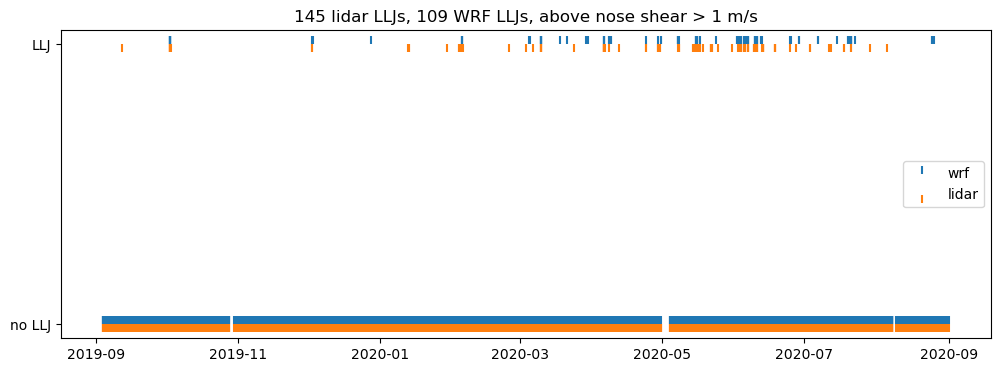

In [18]:
plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.scatter(df_wrf_same.Time, df_wrf_same.LLJ, label='wrf', marker=2)
ax.scatter(LLJs.time, LLJs.LLJ, label='lidar', marker=3)
ax.set_yticks([0, 1])
ax.set_yticklabels(['no LLJ', 'LLJ'])
ax.set_title(f'{len(LLJs.dropna())} lidar LLJs, {len(df_wrf_same.dropna())} WRF LLJs, above nose shear > {shear_thresh} m/s')
ax.legend()

### combine datasets

In [19]:
LLJs.columns

Index(['time', 'nose_ws', 'nose_hgt', 'nose_wd', 'above_shear', 'LLJ'], dtype='object')

In [20]:
df_wrf_same.columns

Index(['Time', 'Nose windspeed (m/s)', 'Nose height (meters)',
       'Wind direction at nose (degrees)', 'Above nose shear (m/s)', 'LLJ'],
      dtype='object')

In [21]:
# make a new dataframe combining all this together
joint_df = pd.DataFrame()
joint_df['date'] = LLJs.time.values
joint_df['lidar_LLJ'] = LLJs.LLJ.values
joint_df['wrf_LLJ'] = df_wrf_same.LLJ.values
joint_df['lidar_nose_hgt'] = LLJs.nose_hgt.values
joint_df['wrf_nose_hgt'] = df_wrf_same['Nose height (meters)'].values
joint_df['lidar_nose_wspd'] = LLJs.nose_ws.values
joint_df['wrf_nose_wspd'] = df_wrf_same['Nose windspeed (m/s)'].values
joint_df['lidar_nose_wdir'] = LLJs.nose_wd.values
joint_df['wrf_nose_wdir'] = df_wrf_same['Wind direction at nose (degrees)'].values
joint_df['lidar_shear'] = LLJs.above_shear.values
joint_df['wrf_shear'] = df_wrf_same['Above nose shear (m/s)'].values

In [22]:
# only times where either dataset has a LLJ
joint_df_LLJ = joint_df[(joint_df.lidar_LLJ==1) | (joint_df.wrf_LLJ==1)]

In [23]:
joint_df_LLJ.date.dt.strftime('%Y-%m-%d_%H').values[:4]

array(['2019-09-12_07', '2019-10-02_16', '2019-10-02_17', '2019-10-02_18'],
      dtype=object)

In [24]:
# joint_df_LLJ.to_csv('summary3_1.csv')

### make plots of the wind speed profiles for those 23 LLJs with the WRF profiles superimposed on top of the observations

In [25]:
def calc_windspeed(ds):
    '''Calculate the wind speed using U and V'''
    U = utils.destagger(ds.U, 3)
    U = U.rename({'west_east_stag': 'west_east'})
    V = utils.destagger(ds.V, 2)
    V = V.rename({'south_north_stag': 'south_north'})
    wspd = np.sqrt((U**2)+(V**2))
    
    return wspd

def get_hgt_arr(ds, lat_idx=200, lon_idx=200):
    '''Returns an array of heights at a given location'''
    PH = utils.destagger(ds['PH'], 1)
    PH = PH.rename({'bottom_top_stag': 'bottom_top'})
    PH = PH.sel(south_north=lat_idx, west_east=lon_idx)

    PHB = utils.destagger(ds['PHB'], 1)
    PHB = PHB.rename({'bottom_top_stag': 'bottom_top'})
    PHB = PHB.sel(south_north=lat_idx, west_east=lon_idx)

    HGT = ds.HGT.sel(south_north=lat_idx, west_east=lon_idx)
    z = np.array((PH+PHB)/9.81-HGT)
    
    return z

In [26]:
def index_containing_substring(the_list, substring):
    for i, s in enumerate(the_list):
        if substring in s:
              return i
    return -1

In [27]:
nwf_files = utils.get_files('nwf')

#### using joint dataset

In [28]:
# get wrf indices
wrf_idxs = [index_containing_substring(nwf_files, t) for t in joint_df_LLJ.date.dt.strftime('%Y-%m-%d_%H').values]

In [29]:
lid_LLJ = df_ws.iloc[[index_containing_substring(df.timestamp.dt.strftime('%Y-%m-%d_%H'), t) for t in joint_df_LLJ.date.dt.strftime('%Y-%m-%d_%H').values]]

In [30]:
ds = xr.open_dataset(nwf_files[wrf_idxs[0]])

In [31]:
# find lat lon index of E06 lidar
# Select lat/lon values
lon_vals = ds.XLONG.sel(Time=0)
lat_vals = ds.XLAT.sel(Time=0)

# Find index of lat lon values  40.95N, -70.59E
lon_idx = utils.find_lat_lon_idx(lon_vals, lat_vals, lon=-73.43, lat=39.55)[1]
lat_idx = utils.find_lat_lon_idx(lon_vals, lat_vals, lon=-73.43, lat=39.55)[0]

# Find actual lat/lon values
lon_val = float(lon_vals.sel(west_east=lon_idx, south_north=lat_idx).values)
lat_val = float(lat_vals.sel(west_east=lon_idx, south_north=lat_idx).values)

In [32]:
def compare_profiles2(idx):
    # wrf dataset
    ds = xr.open_dataset(nwf_files[wrf_idxs[idx]])
    print(ds.XTIME.values)
    
    # get wrf wind speed and heights
    ws = calc_windspeed(ds).isel(Time=0, south_north=lat_idx, west_east=lon_idx)
    z = get_hgt_arr(ds)
    
    # plot both profiles
    plt.plot(ws, z[0], label=f'WRF: {joint_df_LLJ.iloc[idx].wrf_LLJ}')
    plt.scatter(ws, z[0])
    plt.plot(lid_LLJ.iloc[idx].values, hgts, label=f'lidar: {joint_df_LLJ.iloc[idx].lidar_LLJ}')
    plt.scatter(lid_LLJ.iloc[idx].values, hgts)
    
    # add text with more info
#     plt.text(17, 200, f'wrf shear: {joint_df_LLJ.iloc[idx].wrf_shear:.2f}', color='tab:blue', fontsize=12)
#     plt.text(17, 170, f'lidar shear: {joint_df_LLJ.iloc[idx].lidar_shear:.3f}', color='tab:orange', fontsize=12)
#     plt.text(17, 130, f'wrf nose ws: {joint_df_LLJ.iloc[idx].wrf_nose_wspd:.2f}', color='tab:blue', fontsize=12)
#     plt.text(17, 110, f'lidar nose ws: {joint_df_LLJ.iloc[idx].lidar_nose_wspd:.3f}', color='tab:orange', fontsize=12)
    
    plt.ylim(0, 401)
    plt.xlim(0, 25)
    plt.xlabel('Wind speed [m s $^{-1}$]')
    plt.ylabel('Height [m]')
    plt.title(joint_df_LLJ.date.dt.strftime('%Y-%m-%d %H:%M:%S').values[idx])
    plt.legend()
    
    plt.savefig(f"profiles5/p{idx:03}_{joint_df_LLJ.date.dt.strftime('%Y-%m-%d %H:%M:%S').values[idx]}.png")
    plt.close()

In [33]:
nwf_files[wrf_idxs[89]]

'/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2020//05/wrfout_d02_2020-05-15_05:00:00'

In [34]:
compare_profiles2(89)

['2020-05-15T05:00:00.000000000']


In [53]:
for i in range(len(joint_df_LLJ)):
    if joint_df_LLJ.iloc[i].lidar_LLJ==1:
        compare_profiles2(i)

['2019-09-12T07:00:00.000000000']
['2019-10-02T16:00:00.000000000']
['2019-10-02T17:00:00.000000000']
['2019-10-02T18:00:00.000000000']
['2019-10-02T19:00:00.000000000']
['2019-10-02T20:00:00.000000000']
['2019-10-02T21:00:00.000000000']
['2019-10-02T22:00:00.000000000']
['2019-10-02T23:00:00.000000000']
['2019-12-02T12:00:00.000000000']
['2019-12-02T16:00:00.000000000']
['2020-01-13T02:00:00.000000000']
['2020-01-13T03:00:00.000000000']
['2020-01-13T05:00:00.000000000']
['2020-01-29T12:00:00.000000000']
['2020-02-03T22:00:00.000000000']
['2020-02-03T23:00:00.000000000']
['2020-02-04T00:00:00.000000000']
['2020-02-04T01:00:00.000000000']
['2020-02-04T03:00:00.000000000']
['2020-02-04T22:00:00.000000000']
['2020-02-04T23:00:00.000000000']
['2020-02-05T00:00:00.000000000']
['2020-02-05T01:00:00.000000000']
['2020-02-05T02:00:00.000000000']
['2020-02-05T17:00:00.000000000']
['2020-02-25T02:00:00.000000000']
['2020-03-03T17:00:00.000000000']
['2020-03-06T17:00:00.000000000']
['2020-03-09T1

### find the mean LLJ profile for 1 m/s shear in lowest 200m

start with WRF

In [35]:
# get a list of wrf LLJs
wrf_LLJ_idxs = [index_containing_substring(nwf_files, t) for t in df_wrf_same[df_wrf_same.LLJ==1].Time.dt.strftime('%Y-%m-%d_%H').values]

In [36]:
wrf_LLJ_files = [nwf_files[i] for i in wrf_LLJ_idxs]

In [37]:
ds = xr.open_mfdataset(wrf_LLJ_files, 
                       concat_dim = 'Time',
                       combine = 'nested',
                       parallel = True,
                       engine = 'netcdf4',
                       chunks = {'Time':1})

In [38]:
wrf_LLJ_wspd = calc_windspeed(ds)

In [39]:
WRF_mean_profile = wrf_LLJ_wspd.isel(south_north=lat_idx, west_east=lon_idx, bottom_top=slice(0, 17)).mean(dim="Time").values

In [40]:
WRF_std_profile = wrf_LLJ_wspd.isel(south_north=lat_idx, west_east=lon_idx, bottom_top=slice(0, 17)).std(dim="Time").values

In [41]:
z = get_hgt_arr(ds.isel(Time=0))

now find the mean LLJ profile for lidar

In [42]:
lidar_LLJ_profiles = df_ws.iloc[[index_containing_substring(df.timestamp.dt.strftime('%Y-%m-%d_%H'), t) for t in LLJs[LLJs.LLJ==1].time.dt.strftime('%Y-%m-%d_%H').values]]

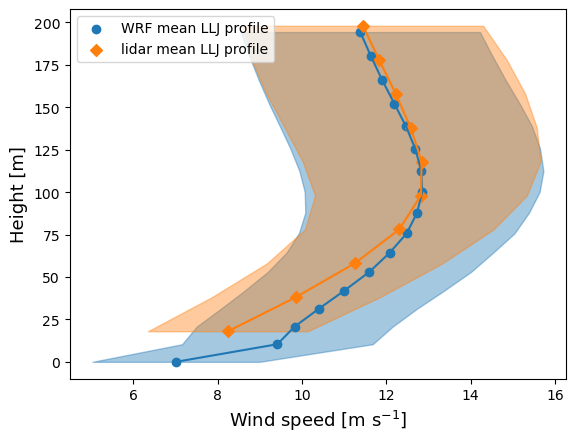

In [79]:
plt.figure()
plt.fill_betweenx(y=z[z<205], 
                  x1=WRF_mean_profile-WRF_std_profile, 
                  x2=WRF_mean_profile+WRF_std_profile,
                  color='tab:blue',
                  alpha=0.4)
plt.fill_betweenx(y=hgts,
                  x1=lidar_LLJ_profiles.mean().values-lidar_LLJ_profiles.std().values,
                  x2=lidar_LLJ_profiles.mean().values+lidar_LLJ_profiles.std().values,
                  color='tab:orange',
                  alpha=0.4)
plt.plot(WRF_mean_profile, z[z<205], color='tab:blue')
plt.scatter(WRF_mean_profile, z[z<205], color='tab:blue', label='WRF mean LLJ profile',)
plt.plot(lidar_LLJ_profiles.mean().values, hgts, color='tab:orange')
plt.scatter(lidar_LLJ_profiles.mean().values, hgts, color='tab:orange', marker='D', label='lidar mean LLJ profile')
plt.xlabel('Wind speed [m s$^{-1}$]', fontsize=13)
plt.ylabel('Height [m]', fontsize=13)
plt.legend()
plt.savefig('mean_profile.png', bbox_inches='tight')

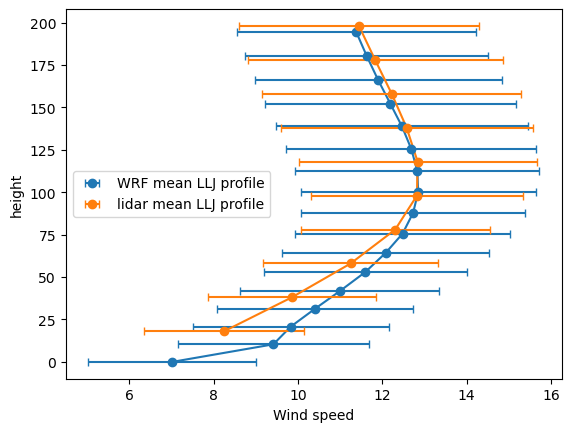

In [65]:
plt.figure()
plt.errorbar(WRF_mean_profile, z[z<205], xerr=WRF_std_profile, fmt='o', capsize=3, label='WRF mean LLJ profile')
plt.plot(WRF_mean_profile, z[z<205], color='tab:blue')
plt.errorbar(lidar_LLJ_profiles.mean().values, hgts, xerr=lidar_LLJ_profiles.std().values, fmt='o', capsize=3, label='lidar mean LLJ profile')
plt.plot(lidar_LLJ_profiles.mean().values, hgts, color='tab:orange')
plt.xlabel('Wind speed')
plt.ylabel('height')
plt.legend()

now look at daily cycle

In [74]:
lidar_monthly = list(LLJs.dropna().groupby(LLJs.time.dt.month).count().time.values)
lidar_monthly.insert(10, 0)

In [75]:
WRF_monthly = list(df_wrf_same.dropna().groupby(df_wrf_same.Time.dt.month).count().Time.values)
WRF_monthly.insert(0, 0)
WRF_monthly.insert(8, 0)
WRF_monthly.insert(10, 0)

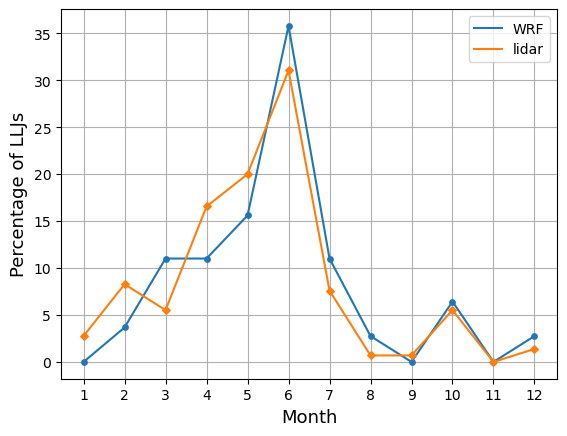

In [84]:
plt.figure()
ax = plt.gca()
ax.grid()
ax.plot(np.arange(1, 13), (WRF_monthly/np.array(WRF_monthly).sum())*100, label='WRF')
ax.plot(np.arange(1, 13), (lidar_monthly/np.array(lidar_monthly).sum())*100, label='lidar')
ax.scatter(np.arange(1, 13), (WRF_monthly/np.array(WRF_monthly).sum())*100, s=15, color='tab:blue', zorder=10)
ax.scatter(np.arange(1, 13), (lidar_monthly/np.array(lidar_monthly).sum())*100, s=15, color='tab:orange', zorder=10, marker='D')
ax.set_xticks(np.arange(1, 13))
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('Percentage of LLJs', fontsize=13)
ax.legend()
plt.savefig('monthly.png', bbox_inches='tight');

make panel

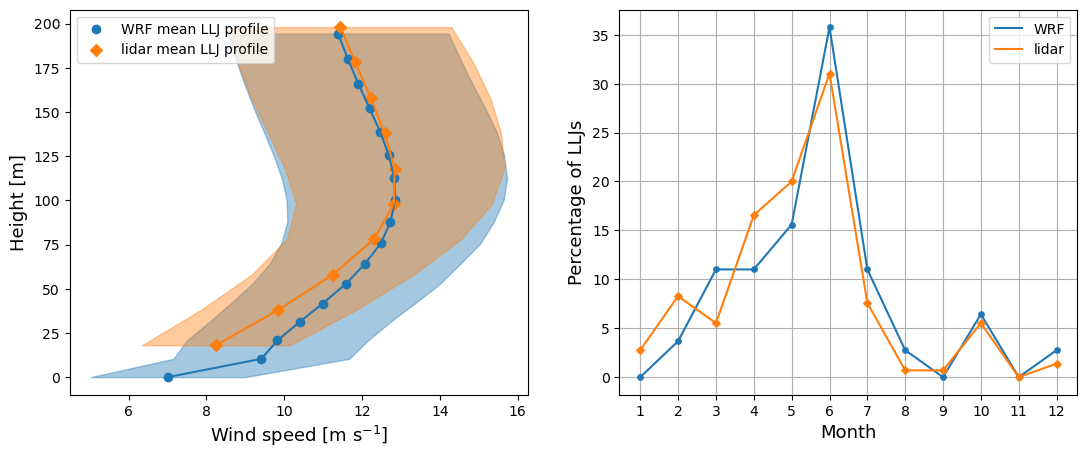

In [89]:
fig, axs = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

axs[0].fill_betweenx(y=z[z<205], 
                  x1=WRF_mean_profile-WRF_std_profile, 
                  x2=WRF_mean_profile+WRF_std_profile,
                  color='tab:blue',
                  alpha=0.4)
axs[0].fill_betweenx(y=hgts,
                  x1=lidar_LLJ_profiles.mean().values-lidar_LLJ_profiles.std().values,
                  x2=lidar_LLJ_profiles.mean().values+lidar_LLJ_profiles.std().values,
                  color='tab:orange',
                  alpha=0.4)
axs[0].plot(WRF_mean_profile, z[z<205], color='tab:blue')
axs[0].scatter(WRF_mean_profile, z[z<205], color='tab:blue', label='WRF mean LLJ profile',)
axs[0].plot(lidar_LLJ_profiles.mean().values, hgts, color='tab:orange')
axs[0].scatter(lidar_LLJ_profiles.mean().values, hgts, color='tab:orange', marker='D', label='lidar mean LLJ profile')
axs[0].set_xlabel('Wind speed [m s$^{-1}$]', fontsize=13)
axs[0].set_ylabel('Height [m]', fontsize=13)
axs[0].legend()

axs[1].grid()
axs[1].plot(np.arange(1, 13), (WRF_monthly/np.array(WRF_monthly).sum())*100, label='WRF')
axs[1].plot(np.arange(1, 13), (lidar_monthly/np.array(lidar_monthly).sum())*100, label='lidar')
axs[1].scatter(np.arange(1, 13), (WRF_monthly/np.array(WRF_monthly).sum())*100, s=15, color='tab:blue', zorder=10)
axs[1].scatter(np.arange(1, 13), (lidar_monthly/np.array(lidar_monthly).sum())*100, s=15, color='tab:orange', zorder=10, marker='D')
axs[1].set_xticks(np.arange(1, 13))
axs[1].set_xlabel('Month', fontsize=13)
axs[1].set_ylabel('Percentage of LLJs', fontsize=13)
axs[1].legend()

fig.savefig('valid_panel.png', bbox_inches='tight')

hourly

In [52]:
lidar_hourly = list(LLJs.dropna().groupby(LLJs.time.dt.hour).count().time.values)
lidar_hourly.insert(10, 0)

In [55]:
wrf_hourly = list(df_wrf_same.dropna().groupby(df_wrf_same.Time.dt.month).count().Time.values)
for i in [0, 1, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:
    wrf_hourly.insert(i, 0)

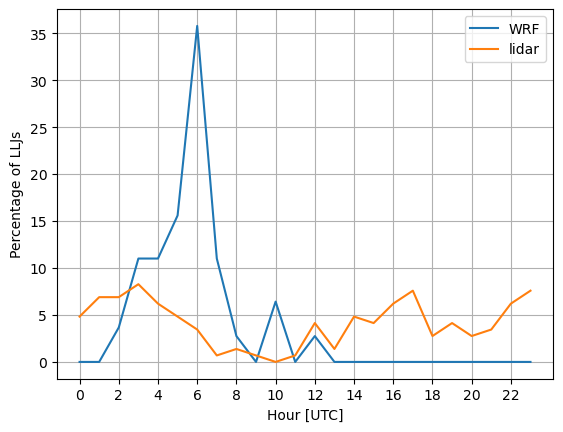

In [60]:
plt.figure()
ax = plt.gca()
ax.grid()
ax.plot(np.arange(0, 24), (wrf_hourly/np.array(wrf_hourly).sum())*100, label='WRF')
ax.plot(np.arange(0, 24), (lidar_hourly/np.array(lidar_hourly).sum())*100, label='lidar')
ax.set_xticks(np.arange(0, 24, 2))
ax.set_xlabel('Hour [UTC]')
ax.set_ylabel('Percentage of LLJs')
ax.legend();

### scatter wrf nose height vs lidar nose height for hits

In [43]:
hits = joint_df_LLJ[(joint_df_LLJ.lidar_LLJ==1) & (joint_df_LLJ.wrf_LLJ==1)]

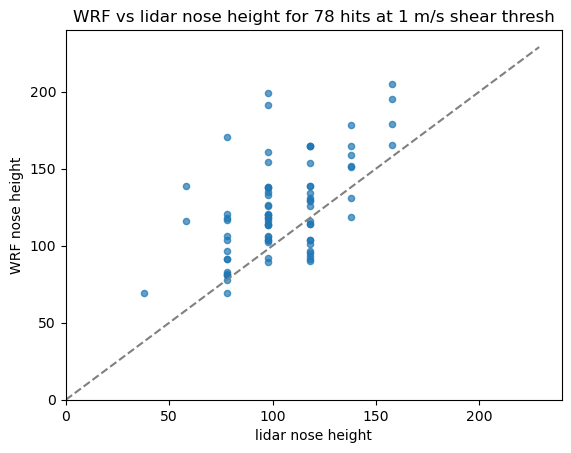

In [44]:
plt.scatter(hits.lidar_nose_hgt, hits.wrf_nose_hgt, s=20, alpha=0.7, marker='o')
plt.ylabel('WRF nose height')
plt.xlabel('lidar nose height')
plt.xlim(0, 240)
plt.ylim(0, 240)
plt.plot(np.arange(0, 230), np.arange(0, 230), linestyle='dashed',  color='grey')
plt.title(f'WRF vs lidar nose height for {len(hits)} hits at 1 m/s shear thresh');

#### end using joint dataset

In [ ]:
LLJs.dropna().time.dt.strftime('%Y-%m-%d_%H').values[:10]

In [ ]:
# indices of LLJs in nwf file list
shear3_idxs = [index_containing_substring(nwf_files[72:], t) for t in LLJs.dropna().time.dt.strftime('%Y-%m-%d_%H').values]

In [ ]:
lid_shear3 = df_ws.iloc[[index_containing_substring(df.timestamp.dt.strftime('%Y-%m-%d_%H'), t) for t in LLJs.dropna().time.dt.strftime('%Y-%m-%d_%H').values]]

In [ ]:
# get wind speed
ws = calc_windspeed(ds)
z = get_hgt_arr(ds)

In [ ]:
wspd = ws.isel(Time=0, south_north=lat_idx, west_east=lon_idx)

In [ ]:
plt.plot(wspd, z[0], label='WRF')
plt.scatter(wspd, z[0])
plt.plot(lid_shear3.iloc[0].values, hgts, label='lidar')
plt.scatter(lid_shear3.iloc[0].values, hgts)
plt.ylim(0, 201)
plt.xlim(0, 15)
plt.xlabel('wspd [m/s]')
plt.ylabel('height [m]')
plt.title(LLJs.dropna().time.dt.strftime('%Y-%m-%d %H:%M:%S').values[0])
plt.legend()

In [ ]:
def compare_profiles(idx):
    # wrf dataset
    ds = xr.open_dataset(nwf_files[72:][shear3_idxs[idx]])
    print(ds.XTIME.values)
    
    # get wrf wind speed and heights
    ws = calc_windspeed(ds).isel(Time=0, south_north=lat_idx, west_east=lon_idx)
    z = get_hgt_arr(ds)
    
    # plot both profiles
    plt.plot(ws, z[0], label='WRF')
    plt.scatter(ws, z[0])
    plt.plot(lid_shear3.iloc[idx].values, hgts, label='lidar')
    plt.scatter(lid_shear3.iloc[idx].values, hgts)
    
    plt.ylim(0, 201)
    plt.xlim(0, 25)
    plt.xlabel('wspd [m/s]')
    plt.ylabel('height [m]')
    plt.title(LLJs.dropna().time.dt.strftime('%Y-%m-%d %H:%M:%S').values[idx])
    plt.legend()
    
    plt.savefig(f"profiles2/p{idx:02}_{LLJs.dropna().time.dt.strftime('%Y-%m-%d %H:%M:%S').values[idx]}.png")
    plt.close()

for 3 m/s thresh

In [ ]:
for i in range(23):
    compare_profiles(i)

for 1 m/s thresh

In [ ]:
for i in range(145):
    compare_profiles(i)